# Decompose QSO image from HST observation

This notebook requires standard python libraries and the publicly available packages on github:
See https://github.com/dartoon/galight/blob/master/requirements.txt

This fitting approach has been first introduced in Ding et al. 2020 ApJ 888 37 https://ui.adsabs.harvard.edu/abs/2020ApJ...888...37D/abstract

This notebook has been tested with galight ==  0.1.13

For more information, please contact me: dingxuheng@126.com

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits

#Data is available at: https://drive.google.com/file/d/1Axwo-aD5yFrkuHIlYBsQ8ma1nHRpcAHg/view?usp=sharing
#this drizzled image is based on HST Programme GO-15115 (PI: John Silverman),
#More details see Ding et al. 2020 ApJ 888 37 

fitsFile = pyfits.open('../example_files/HST/QSO/1147_final_drz.fits')  

#Load the fov image data:
fov_image = fitsFile[1].data # check the back grounp

#Derive the header informaion, might be used to obtain the pixel scale and the exposure time.
header = fitsFile[1].header # if target position is add in WCS, the header should have the wcs information, i.e. header['EXPTIME']

In [2]:
import galight.tools.astro_tools as astro_tools

#Load the WHT map, which would be use to derive the exposure map
wht = fitsFile[2].data

exp =  astro_tools.read_fits_exp(fitsFile[0].header)  #Read the exposure time 
mean_wht = exp * (0.0642/0.135)**2  #The drizzle information is used to derive the mean WHT value.
exp_map = exp * wht/mean_wht  #Derive the exposure time map for each pixel

## use ``galight`` to process the data
- keywords in DataProcess():
    - target_pos: location of the object, default in Pixel, if [RA, Dec] is given, pos_type = 'wcs'
    - rm_bkglight: If True -- automaticlly estiamte the background light and remove.
    - zp: zeropoint value. use 27.0 for convinence.
    
- keywords in data_process.generate_target_materials()
    - radius: the radius of the cutout stamp of the QSO image, framze size = 2 * radius + 1
    - create_mask: If true, will create mask for the neighbouring objects.
    - nsigma: The s/n defined to detect all the objects in the image stamp
    - npixels: The number of connected pixels, each greater than ``threshold``,
        that an object must have to be detected.  ``npixels`` must be a
        positive integer.
    - (nsigma and npixels are introduced from photutils, method introduced in:
    https://photutils.readthedocs.io/en/stable/segmentation.html#source-deblending )
    - exp_sz: The expend level for the detected object region.
    
    

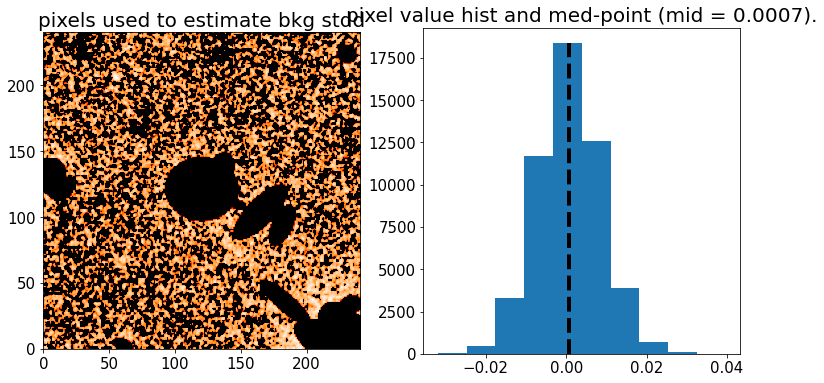

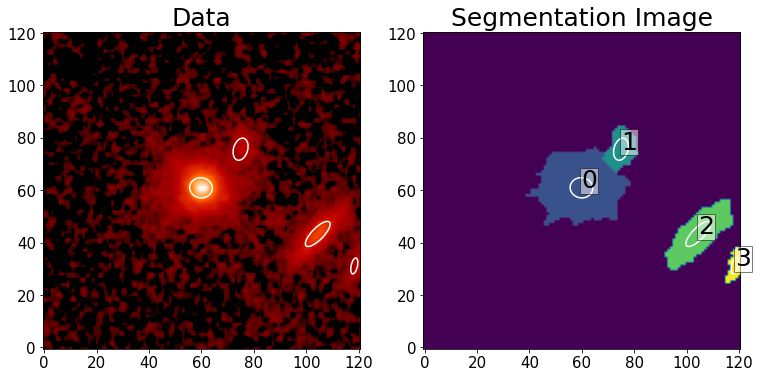

Input directly the a obj that used to create MASK, use space between each id:
2


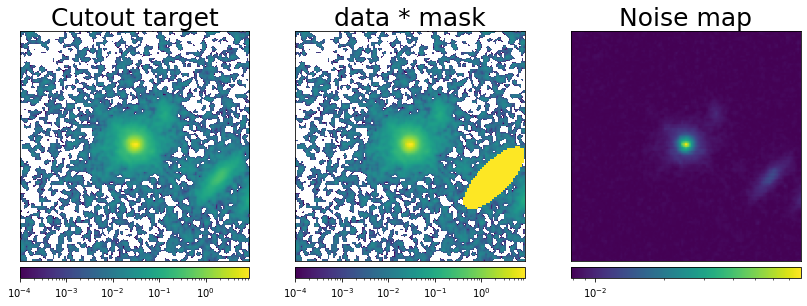

In [3]:
from galight.data_process import DataProcess

#keywords see the notes above.
data_process = DataProcess(fov_image = fov_image, target_pos = [1142., 637.], pos_type = 'pixel', header = header,
                          rm_bkglight = False, exptime = exp_map, if_plot=False, zp = 27.0)  #zp use 27.0 for convinence.

data_process.generate_target_materials(radius=60, create_mask = True, nsigma=2.8,
                                      exp_sz= 1.2, npixels = 15, if_plot=True)

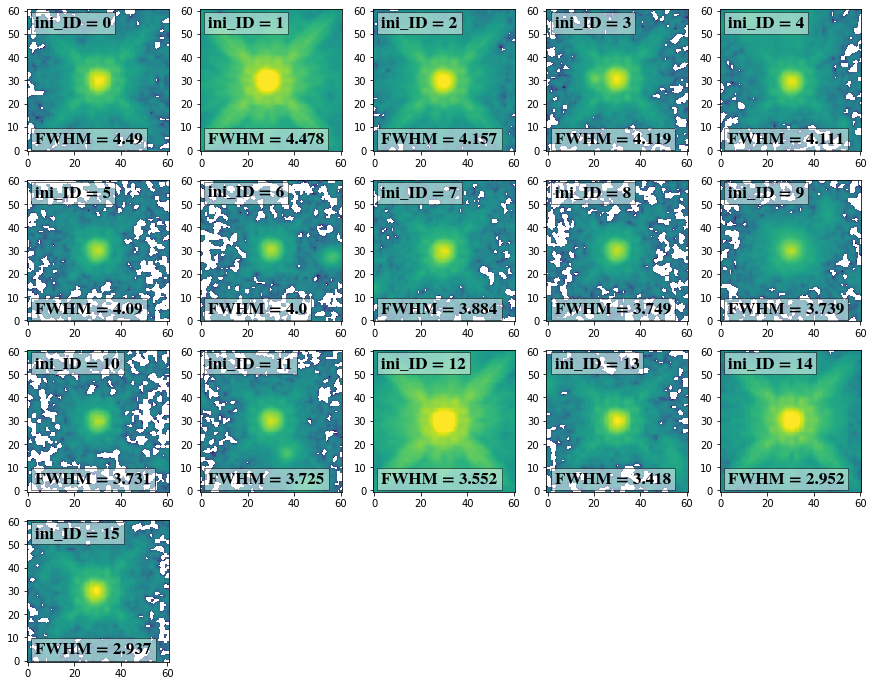

Input directly the PSF inital id to select, use space between each id:
 (press Enter to selet all)
15


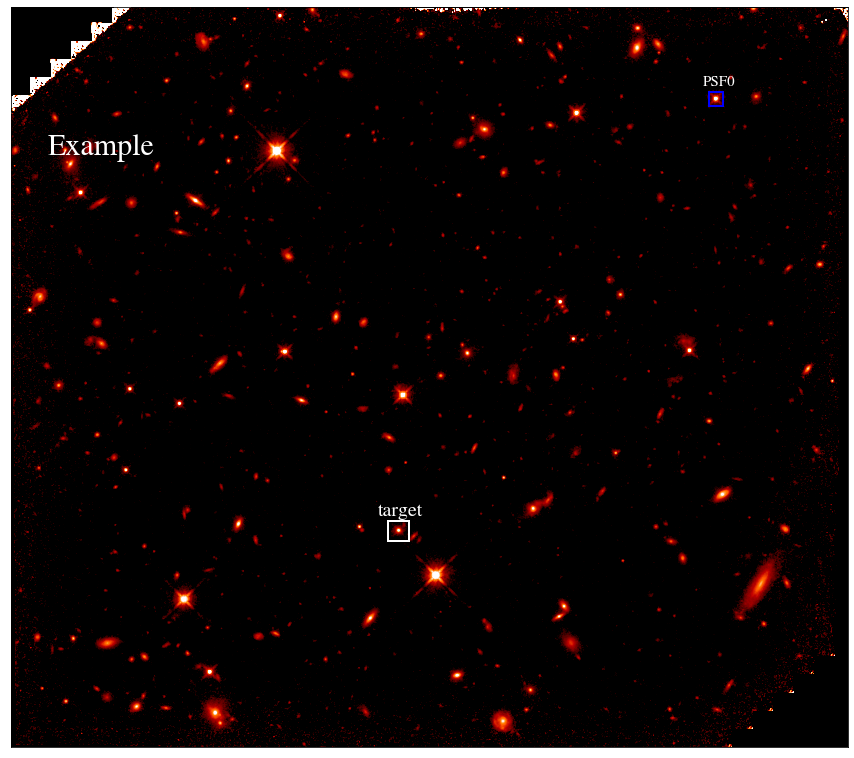

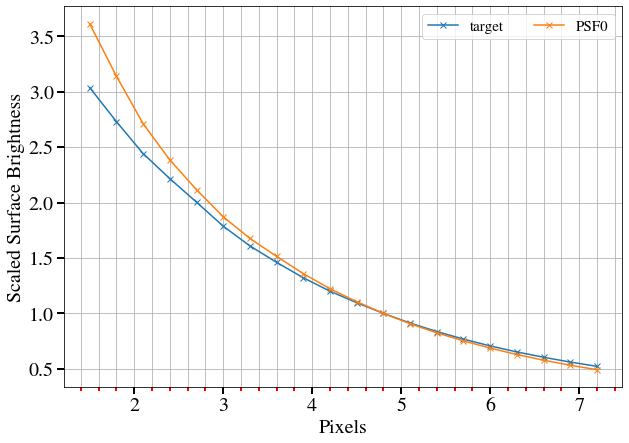

KeyboardInterrupt: Interrupted by user

In [4]:
#find_PSF(): find all the available PSF in the field
#     radius: The radius to cutout the PSF
#     PSF_pos_list: input if PSF positions have selected, input. (combining with pos_type = 'pixel' (default) or 'wcs')
#     if input user_option = False: the one with smallest FWHM would be selected,
#     if input user_option = True: the user can make selection    
#data_process.find_PSF(radius = 30, PSF_pos_list = [[ 350., 1055.], [2078., 1910.]])
# data_process.find_PSF(radius = 30, user_option = False) #Try this line out! 
data_process.find_PSF(radius = 30, user_option = True)  #Try this line out! 

#Plot the FOV image and label the position of the target and the PSF
data_process.plot_overview(label = 'Example', target_label = None)

# Compare the 1D profile of all the components.
data_process.profiles_compare(norm_pix = 5, if_annuli=False, y_log = False,
                  prf_name_list = (['target'] + ['PSF{0}'.format(i) for i in range(len(data_process.PSF_list))]) )

#Select which PSF id you want to use to make the fitting.
data_process.psf_id_for_fitting = int(input('Use which PSF? Input a number.\n'))

#Check if all the materials is given, if so to pass to the next step.
data_process.checkout()

## The following box would quickly prepare the models, parameters and fitting details.

### prepare_fitting_seq includes the following keywords:
    
- point_source_num: number of point source want to used to make the fiting. 
    - point_source_num = 0: galaxy 1: QSO 2: dual AGN
- fix_n_list
    - if one wants to fix any Sersic index value for the component, [[0,4]] means fix Sersic_n of source_id = 0 to 4.
- fix_center_list:
    - if one wants to fix the QSO center to the galaxy center, [0, 1] means fix galaxy_id = 0 center to the QSO_id = 1.
- extend_source_model: manually input the models for the Sersics, i.e., ['SERSIC_ELLIPSE'] * n, n = number of Sersics.
- source_params, ps_params: manually input the galaxy paramters and PS parameters.
    
    

The settings for the fitting is done. Ready to pass to FittingProcess. 
  However, please make updates manullay if needed.


/Users/Dartoon/opt/anaconda3/envs/galight/lib/python3.10/site-packages/lenstronomy/Data/psf.py:60: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn('Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.')


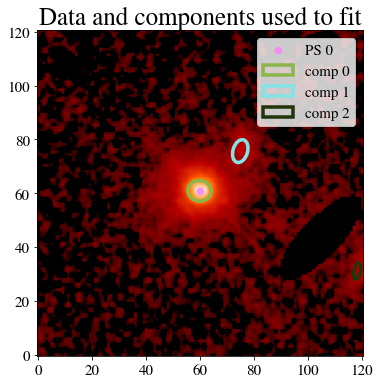

In [6]:
#Produce the class and params to make the QSO decomposition.
from galight.fitting_specify import FittingSpecify

#Pass the data_process to FittingSpeficy
fit_sepc = FittingSpecify(data_process)

#Prepare the fitting sequence, keywords see notes above.
fit_sepc.prepare_fitting_seq(point_source_num = 1, fix_n_list= [[0,4]], fix_center_list = [[0,0]], 
                            extend_source_model=None, source_params = None, ps_params = None)

#Plot the initial settings for fittings. 
fit_sepc.plot_fitting_sets()

#Build up and to pass to the next step.
fit_sepc.build_fitting_seq()

Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-1.884666662667888 reduced X^2 of best position
-13317.054638411297 log likelihood
14132.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.14373746959811284, 'n_sersic': 4, 'e1': 0.06753943761015124, 'e2': 0.04296289902273972, 'center_x': -0.056432079871853044, 'center_y': 0.05685035710369125}, {'amp': 1, 'R_sersic': 0.39247959361227586, 'n_sersic': 1.510724507025018, 'e1': -0.2613633162767057, 'e2': 0.03974302846425745, 'center_x': -1.0565965165113878, 'center_y': 1.095864724126382}, {'amp': 1, 'R_sersic': 0.3024396992162439, 'n_sersic': 8.399967907653275, 'e1': -0.3366618016477973, 'e2': -0.17052523536427755, 'center_x': -3.9877520864046963, 'center_y': -1.6702870448014926}] lens light result
[{'ra_image': array([-0.05643208]), 'dec_image': array([0.05685036]), 'point_amp': array([1.])}] point source result
{} special param result
10.94058609008789 time used for  PSO


100%|█████████████████████████████████████████| 130/130 [01:39<00:00,  1.31it/s]


Computing the MCMC...
Number of walkers =  170
Burn-in iterations:  100
Sampling iterations (in current run): 130
100.16824412345886 time taken for MCMC sampling
111.429 total time taken for the overall fitting (s)
============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ 
Start transfering the Params to fluxs...
5100 MCMC samplers in total, finished translate: 1000
5100 MCMC samplers in total, finished translate: 2000
5100 MCMC samplers in total, finished translate: 3000
5100 MCMC samplers in total, finished translate: 4000
5100 MCMC samplers in total, finished translate: 5000


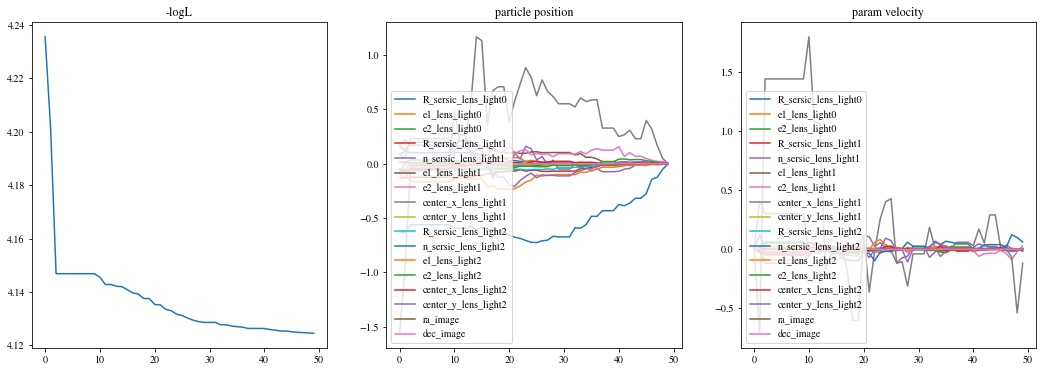

<Figure size 432x288 with 0 Axes>

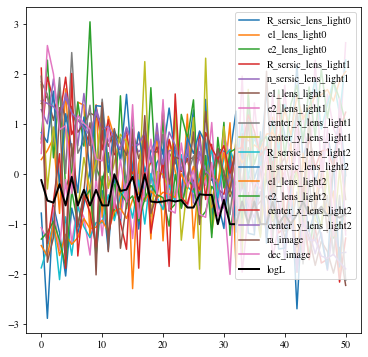

/Users/Dartoon/opt/anaconda3/envs/galight/lib/python3.10/site-packages/lenstronomy/Data/psf.py:60: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn('Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.')
/Users/Dartoon/opt/anaconda3/envs/galight/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/Users/Dartoon/opt/anaconda3/envs/galight/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: invalid value encountered in log10
  log_model = np.log10(model)
/Users/Dartoon/opt/anaconda3/envs/galight/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/Dartoon/opt/anaconda3

-1.8777429153030825 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.8777429153030825


/Users/Dartoon/opt/anaconda3/envs/galight/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:538: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data - model), origin='lower', vmin=v_min, vmax=v_max,


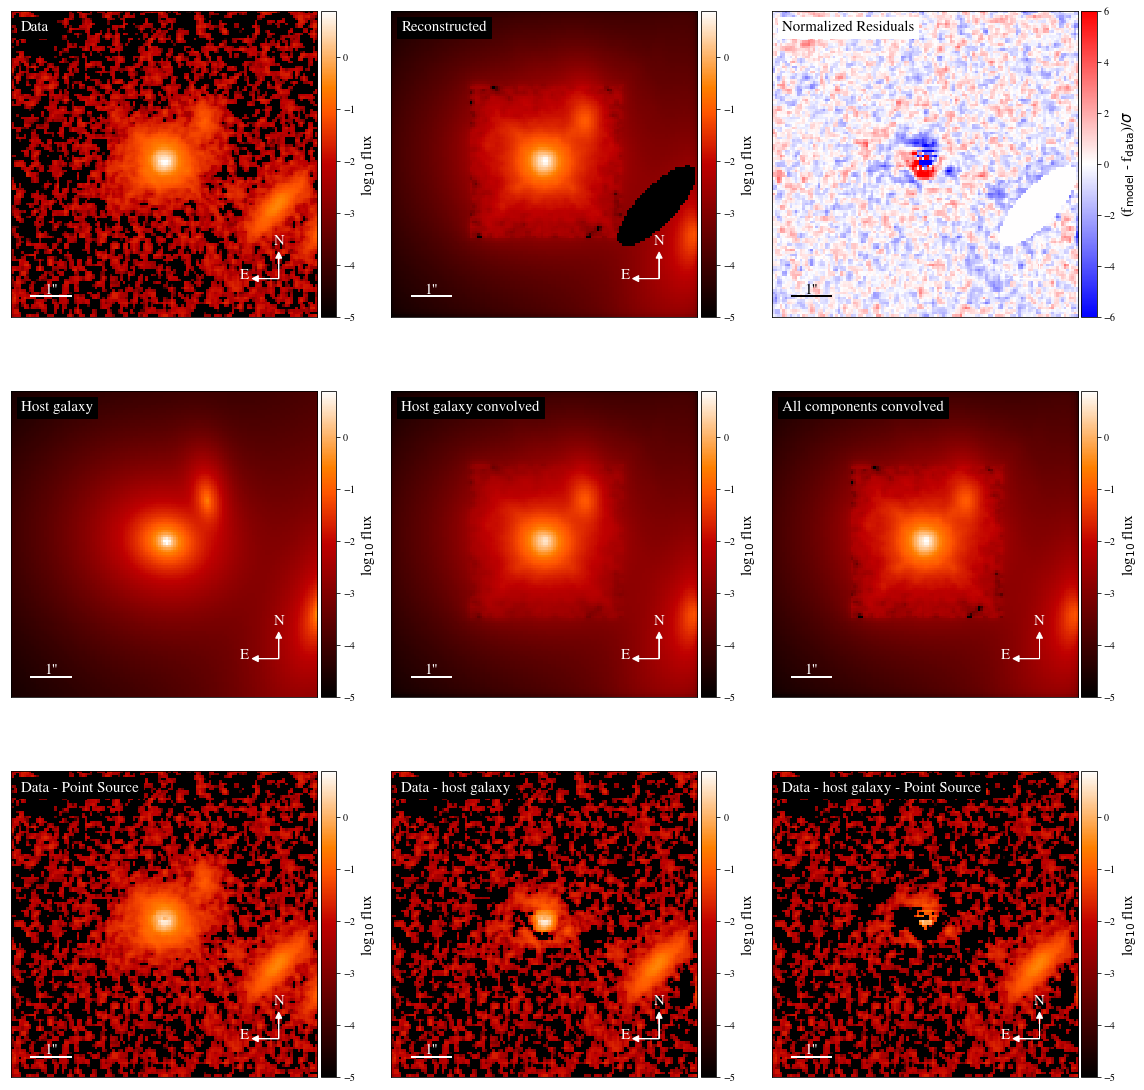

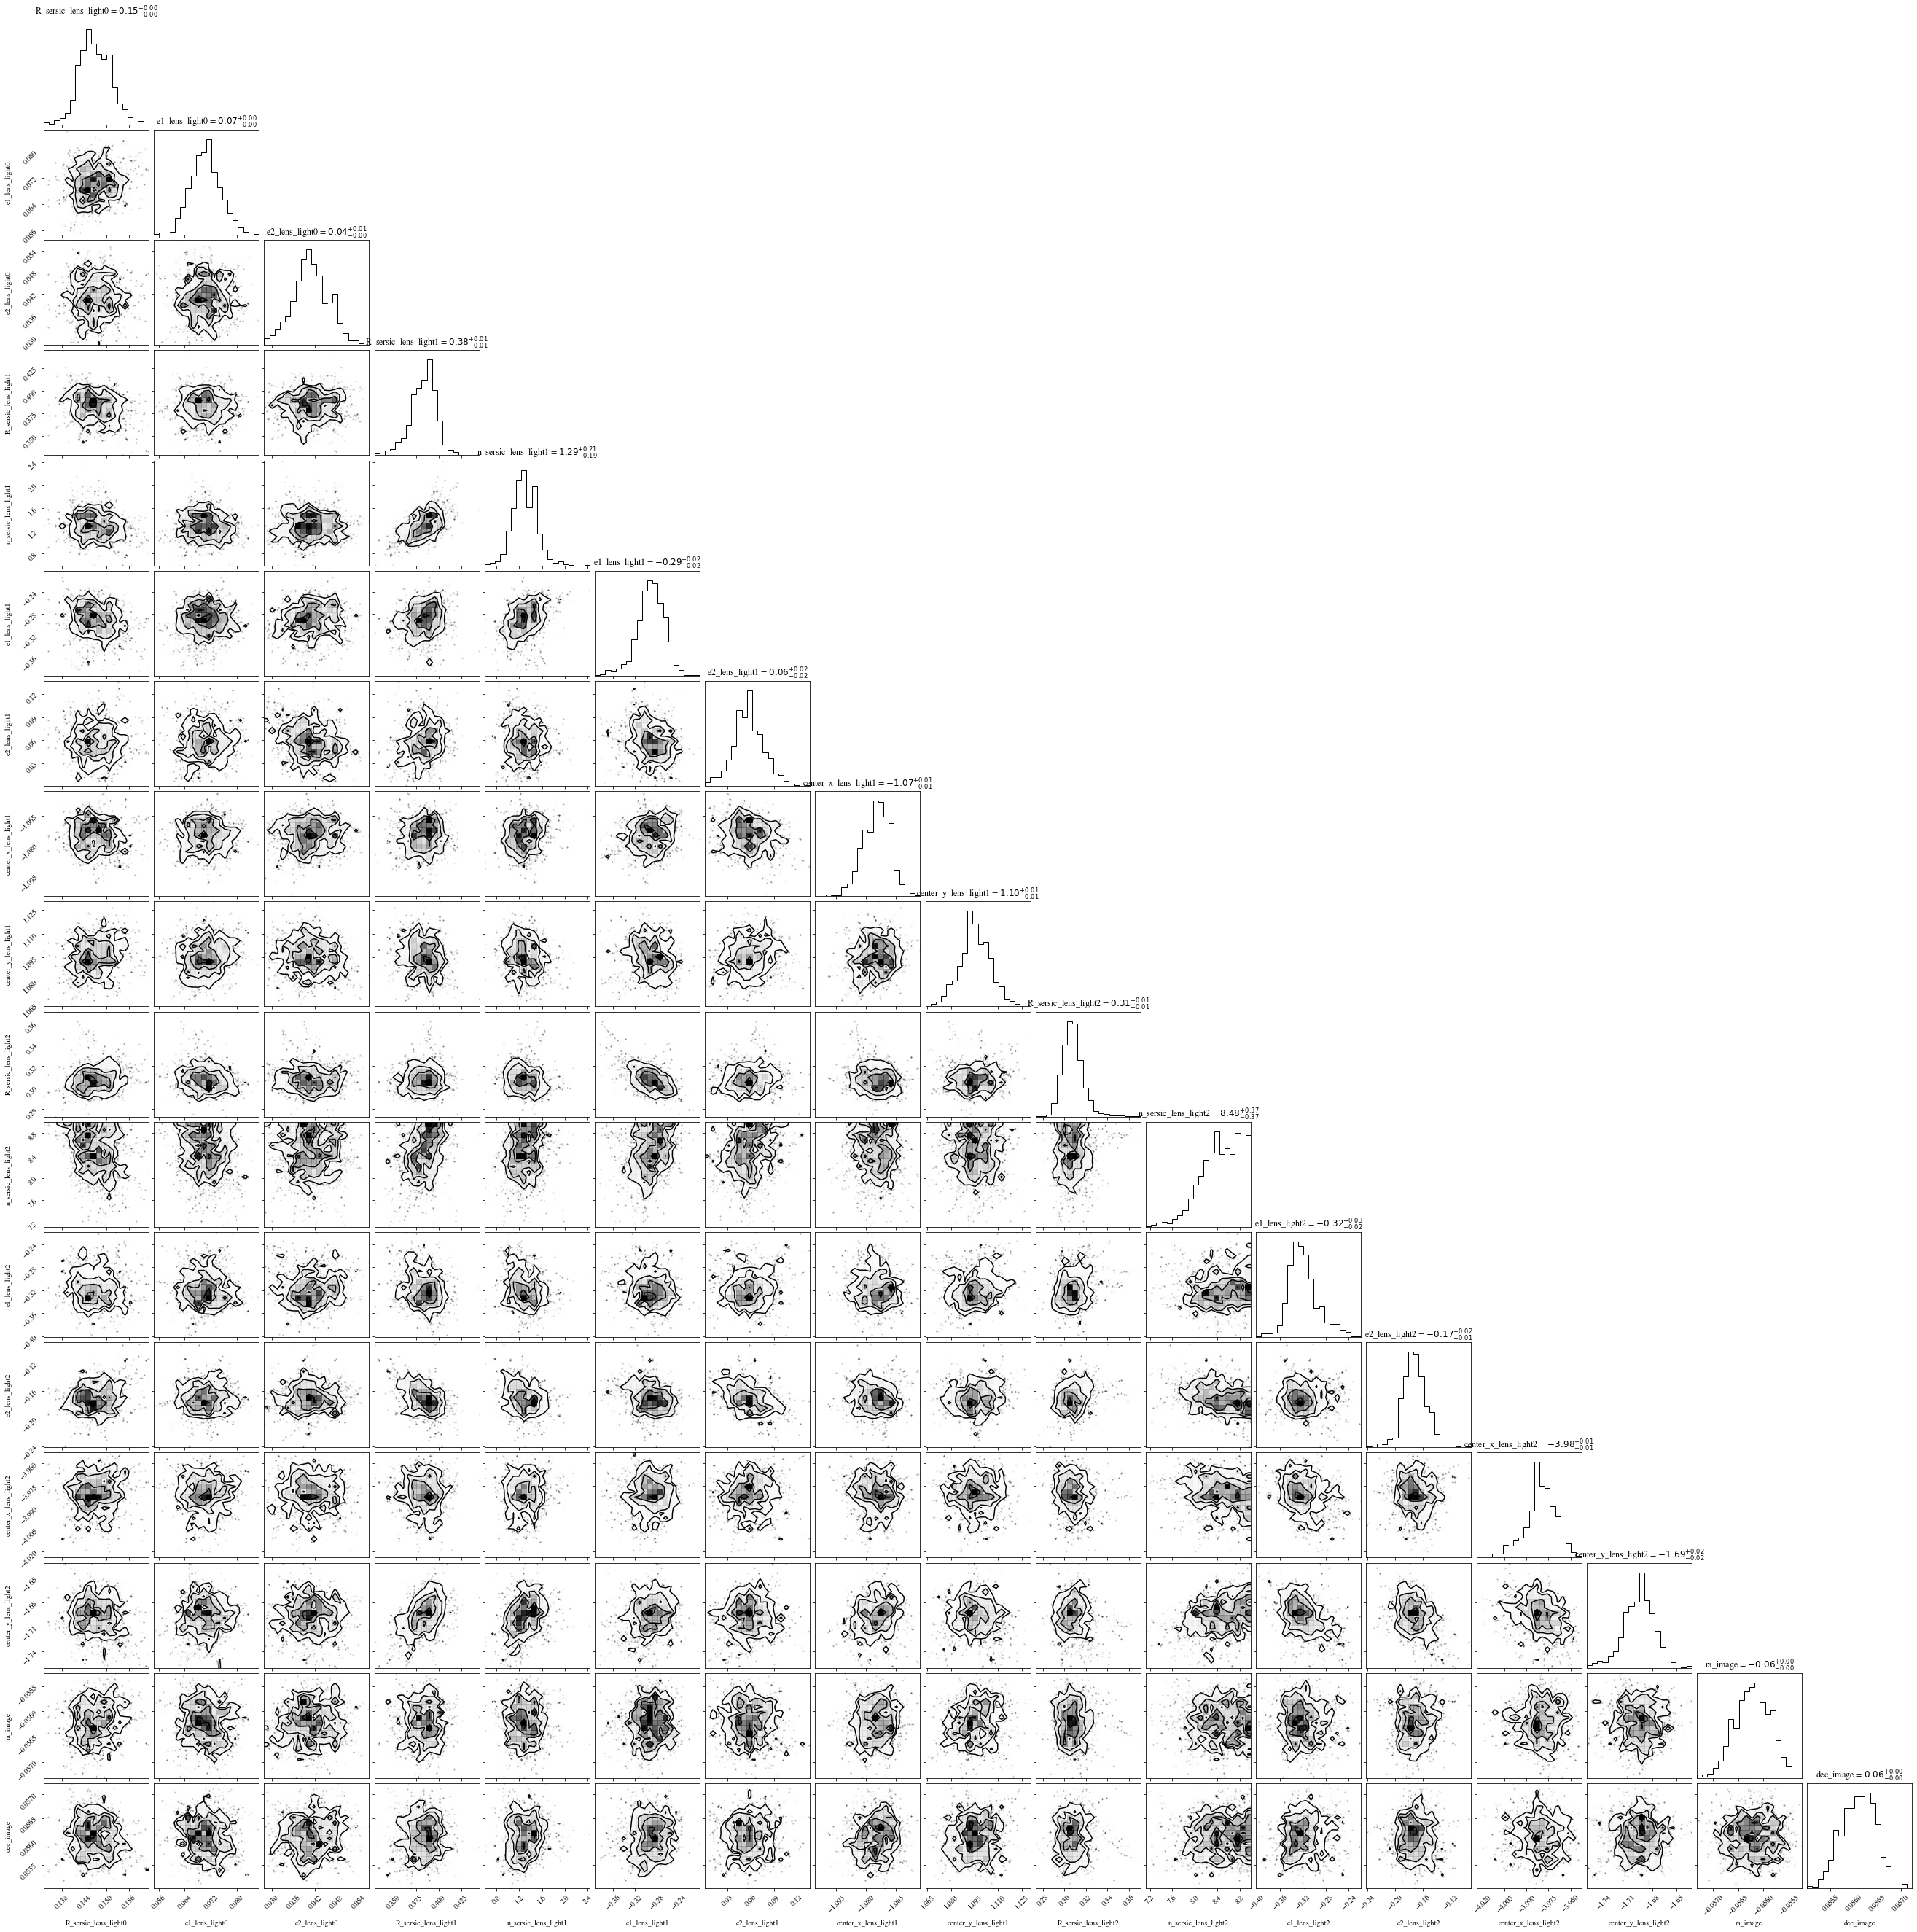

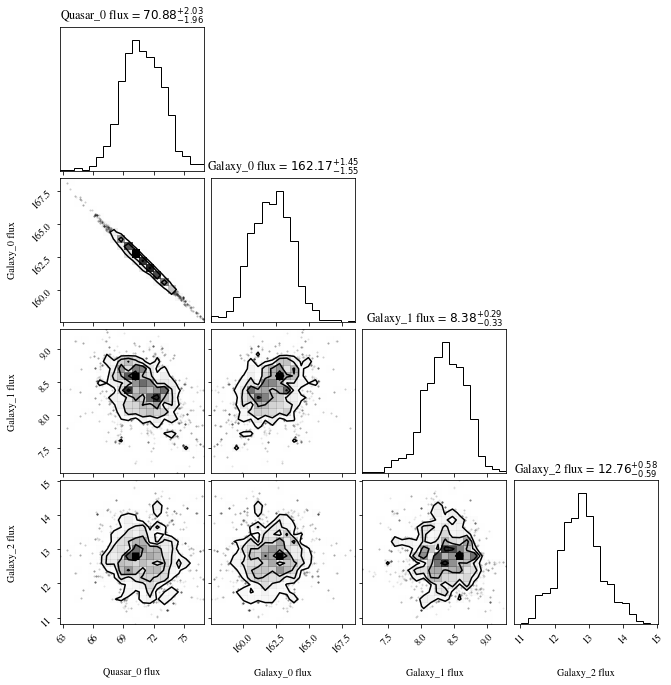

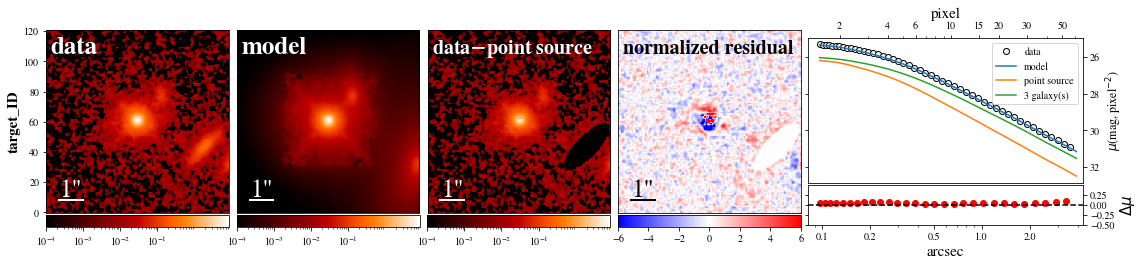

In [7]:
#Setting the fitting method and run.
from galight.fitting_process import FittingProcess

#Pass fit_sepc to FittingProcess,
# savename: The name of the saved files.    
fit_run = FittingProcess(fit_sepc, savename = 'HST_result', fitting_level='norm') 
#For the fitting_level, you can also put ['norm', 'deep'] for the later ['PSO', 'MCMC'] corresplingly.

#Setting the fitting approach and Run: 
#     algorithm_list: The fitting approaches that would be used: e.g. ['PSO', 'PSO', 'MCMC']
#     setting_list: The detailed setting for the fitting:
#     -for PSO:
#         input template: {'sigma_scale': 0.8, 'n_particles': 50, 'n_iterations': 50}
#     -for MCMC:
#         input template: {'n_burn': 50, 'n_run': 100, 'walkerRatio': 10, 'sigma_scale': .1}
#     if setting_list = [None, None, None], default values would be given 
fit_run.run(algorithm_list = ['PSO', 'MCMC'], setting_list = None)

# Plot all the fitting results, including:
#         run_diag() : The convergence of the chains.
#         model_plot(): The model plot (by lenstronomy)
#         plot_params_corner(): The mcmc corner for all the chains (MCMC should be peformed) 
#         plot_flux_corner(): The flux corner for all the component (MCMC should be peformed)
#         plot_final_qso_fit() or plot_final_galaxy_fit(): Plot the overall plot (data, model, data-ps, resudal, 1D profile)
fit_run.plot_all()

#Save the fitting class as pickle format:
#     Note, if you use python3 (or 2), load with python3 (or 2)
fit_run.dump_result()

In [8]:
#For the fugure, one can load the saved fitting class using pickle.
#The entire fit_sepc() and fit_run() in previous fittings can be reloaded.
import pickle
picklename = 'HST_result.pkl'
fitting_run_result = pickle.load(open(picklename,'rb')) #fitting_run_result is actually the fit_run in previous box.
#fitting_run_result.plot_final_qso_fit()
fitting_run_result.final_result_galaxy

[{'amp': 391.79872615137344,
  'R_sersic': 0.14758946363243497,
  'n_sersic': 4,
  'e1': 0.06886723672183898,
  'e2': 0.03793820969451698,
  'center_x': -0.05609042295540677,
  'center_y': 0.05614023606401203,
  'phi_G': 0.25176278048323075,
  'q': 0.8542112991763717,
  'flux_sersic_model': 165.23072534013156,
  'flux_within_frame': 161.81843729149978,
  'magnitude': 21.477429992999436},
 {'amp': 8.19087767284888,
  'R_sersic': 0.39048542640147027,
  'n_sersic': 1.270031098017159,
  'e1': -0.3242606928787853,
  'e2': 0.0761020089903624,
  'center_x': -1.0749093374126462,
  'center_y': 1.0896233623350866,
  'phi_G': 1.4555353931828037,
  'q': 0.5002948085546087,
  'flux_sersic_model': 165.23072534013156,
  'flux_within_frame': 8.287219297284874,
  'magnitude': 24.703977921642835},
 {'amp': 42.93023369067363,
  'R_sersic': 0.32270355767119274,
  'n_sersic': 8.754806323007736,
  'e1': -0.2802512973923845,
  'e2': -0.19765730444281407,
  'center_x': -3.9834584557334773,
  'center_y': -1.70

### Optional: Use statmorph to measure the non-parametric values, see also the following link for Galight's measure by itself:
https://github.com/dartoon/galight_notebooks/blob/master/galight_measure_asymmetry_CAS.ipynb


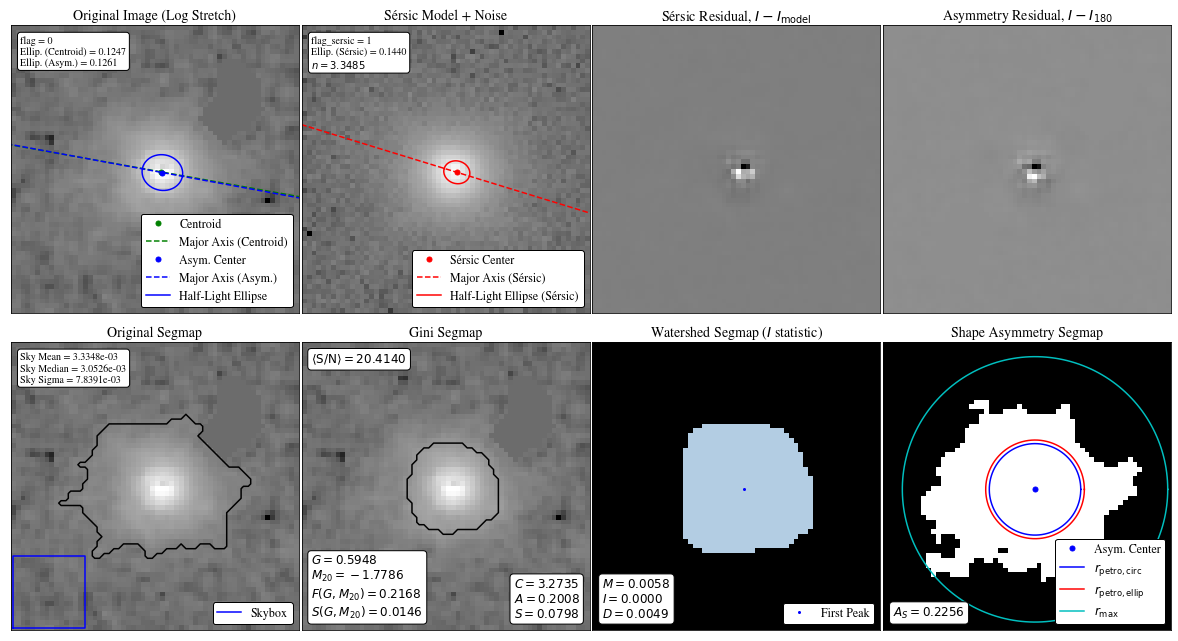

xc_asymmetry = 60.100953476814595
yc_asymmetry = 60.86266320556766
ellipticity_asymmetry = 0.1261309974201391
elongation_asymmetry = 1.1443362758580196
orientation_asymmetry = -0.18310187356421057
C = 3.2734781273615132
A = 0.2007807512420158
S = 0.0798414887561187


In [9]:
morph = fitting_run_result.cal_statmorph(obj_id=0)
from statmorph.utils.image_diagnostics import make_figure
fig = make_figure(morph)
plt.show()
print('xc_asymmetry =', morph.xc_asymmetry)
print('yc_asymmetry =', morph.yc_asymmetry)
print('ellipticity_asymmetry =', morph.ellipticity_asymmetry)
print('elongation_asymmetry =', morph.elongation_asymmetry)
print('orientation_asymmetry =', morph.orientation_asymmetry)
print('C =', morph.concentration)
print('A =', morph.asymmetry)
print('S =', morph.smoothness)